# Flash crash: what was special?

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import sys
import os 
import matplotlib.pyplot as plt

sys.path.append('C:\Projects\FIN-525')


def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
   
    try:
        DF = pd.read_csv(filename)
    except:
        return None
    
    if DF.shape[0] ==0:
        return None
    
    
    
    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF

def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
        
    try:
        DF = pd.read_csv(filename)
    except:
        return None
    
    if DF.shape[0] ==0:
        return None
    
    DF=DF[DF["ask-volume"]>0]
    DF=DF[DF["ask-price"]>0]
    DF=DF[DF["bid-volume"]>0]
    DF=DF[DF["bid-price"]>0]
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [2]:
def loadEvents(ticker,date,dirData="/Users/mmark/Documents/FinancialBigData/data/intraday/equities/US"):
    what="bbo"
    file_bbo=dirData+"/"+what+"/"+ticker+"/"+date+"-"+ticker+"-"+what+".csv.gz"
    print()
    bbos=load_TRTH_bbo(file_bbo)
    bbos["mid"]=(bbos["bid-price"]+bbos["ask-price"])*0.5
    
    what="trade"
    file_trade=dirData+"/"+what+"/"+ticker+"/"+date+"-"+ticker+"-"+what+".csv.gz"
    trades=load_TRTH_trade(file_trade)
    
    events=trades.join(bbos, how='inner')
    events["s"]=np.sign(events["trade_price"]-events["mid"])
    events=events[events["s"]!=0]
    events=events.groupby(events.index).last()
    return events

In [3]:
events_05=loadEvents("SPY.P","2010-05-05")
events_06=loadEvents("SPY.P","2010-05-06")
events_07=loadEvents("SPY.P","2010-05-07")


In [4]:
events_05.head(10)

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,mid,s
xltime,,,,,,,,
2010-05-05 09:30:01.184976-04:00,116.540000,500,116.51,1049,116.53,32,116.520,1.0
2010-05-05 09:30:01.193961600-04:00,116.540000,1800,116.51,1056,116.53,32,116.520,1.0
2010-05-05 09:30:01.212019200-04:00,116.520000,600,116.51,1074,116.53,5,116.520,-1.0
2010-05-05 09:30:01.252022399-04:00,116.523333,500,116.52,40,116.54,88,116.530,-1.0
2010-05-05 09:30:01.501977599-04:00,116.520000,700,116.52,100,116.55,8,116.535,-1.0
2010-05-05 09:30:02.069020800-04:00,116.530000,12731,116.52,32,116.53,108,116.525,1.0
2010-05-05 09:30:02.095027200-04:00,116.527500,24536,116.52,26,116.53,93,116.525,1.0
2010-05-05 09:30:02.095977600-04:00,116.530000,2100,116.52,26,116.53,106,116.525,1.0
2010-05-05 09:30:02.102025600-04:00,116.540000,1700,116.52,18,116.53,107,116.525,1.0


In [5]:
events_05.shift(1).head()

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,mid,s
xltime,,,,,,,,
2010-05-05 09:30:01.184976-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-05 09:30:01.193961600-04:00,116.540000,500.0,116.51,1049.0,116.53,32.0,116.52,1.0
2010-05-05 09:30:01.212019200-04:00,116.540000,1800.0,116.51,1056.0,116.53,32.0,116.52,1.0
2010-05-05 09:30:01.252022399-04:00,116.520000,600.0,116.51,1074.0,116.53,5.0,116.52,-1.0
2010-05-05 09:30:01.501977599-04:00,116.523333,500.0,116.52,40.0,116.54,88.0,116.53,-1.0


In [6]:
def compute_R(events,tau_max=1000,dtau=1):
    taus=range(1,tau_max,dtau)
    events_mid_shifted=events["mid"]
    R=[]
    R_plus=[]
    R_minus=[]
    for tau in taus:
        events_mid_shifted=events_mid_shifted.shift(dtau)
        R.append(np.nanmean(-events["s"]*(events_mid_shifted-events["mid"])))  # - sign instead of shift(-dtau)
    return np.array(R)

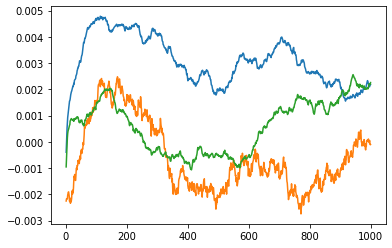

In [7]:
import matplotlib.pyplot as plt

tau_max=1000
dtau=1

R_05=compute_R(events_05,tau_max=tau_max,dtau=dtau)
R_06=compute_R(events_06,tau_max=tau_max,dtau=dtau)
R_07=compute_R(events_07,tau_max=tau_max,dtau=dtau)


taus=range(1,tau_max,dtau)
plt.plot(taus,R_05)   # blue
plt.plot(taus,R_06)   # green
plt.plot(taus,R_07)   # orange

It is thus hard to know if 2010-05-06 was really special

## Over several months

(including the flash crash day)

In [8]:
allevents=pq.read_table("allevents.parquet").to_pandas()   # note that this contains 2010-05-06 flash crash
allevents["mid"]=(allevents["ask-price"]+allevents["bid-price"])*0.5
allevents["s"]=np.sign(allevents["trade_price"]-allevents["mid"])
allevents=allevents[allevents["s"]!=0]

In [9]:
allevents.head(5)

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,mid,s
xltime,,,,,,,,
2010-01-04 09:30:00.615000-05:00,213.5375,1130.0,213.46,1,213.53,1,213.495,1.0
2010-01-04 09:30:00.615000-05:00,213.5375,1130.0,213.40,1,213.53,1,213.465,1.0
2010-01-04 09:30:00.636000-05:00,213.5000,100.0,213.44,1,213.55,4,213.495,1.0
2010-01-04 09:30:00.636000-05:00,213.5000,100.0,213.46,1,213.55,4,213.505,-1.0
2010-01-04 09:30:00.648000-05:00,213.5500,100.0,213.47,1,213.55,3,213.510,1.0


In [13]:
R_all=compute_R(allevents,tau_max=50000,dtau=10)

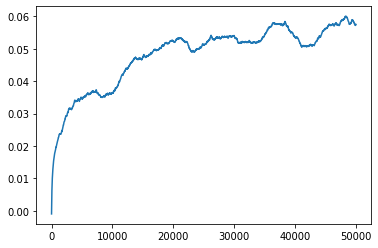

In [14]:
plt.plot(range(1,50000,10),R_all)

And now hour by hour

In [15]:
R_all_hour=allevents[["s","mid"]].groupby(allevents.index.hour).apply(compute_R,tau_max=5000)

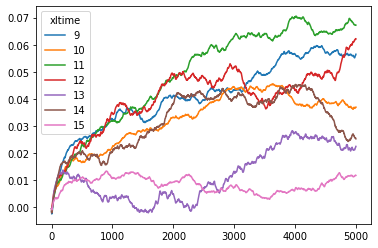

In [16]:
pd.pivot_table(R_all_hour.apply(pd.Series),columns=R_all_hour.index).plot()

The response function thus decreases as a function of the time of the day.

## Flash Crash

Text(0.5, 0, '')

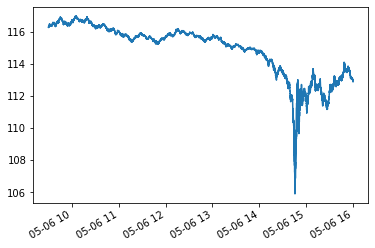

In [17]:
events_06["mid"].plot()
plt.xlabel("")
#plt.savefig("SPY_flashcrash.pdf")

In the following, one tries to see what happened by smaller period of times

In [18]:
coarse_factor=5
events_06["dt"]=coarse_factor*((events_06.index.hour*60+events_06.index.minute)//coarse_factor)/60                            # chunks of 15 minutes
R_06_dt=events_06[["s","mid"]].groupby(events_06["dt"]).apply(compute_R,tau_max=10)
R_06_dt_plus=events_06[["s","mid"]][events_06["s"]>0].groupby(events_06["dt"]).apply(compute_R,tau_max=10)
R_06_dt_minus=events_06[["s","mid"]][events_06["s"]<0].groupby(events_06["dt"]).apply(compute_R,tau_max=10)

(-0.05, 0.05)

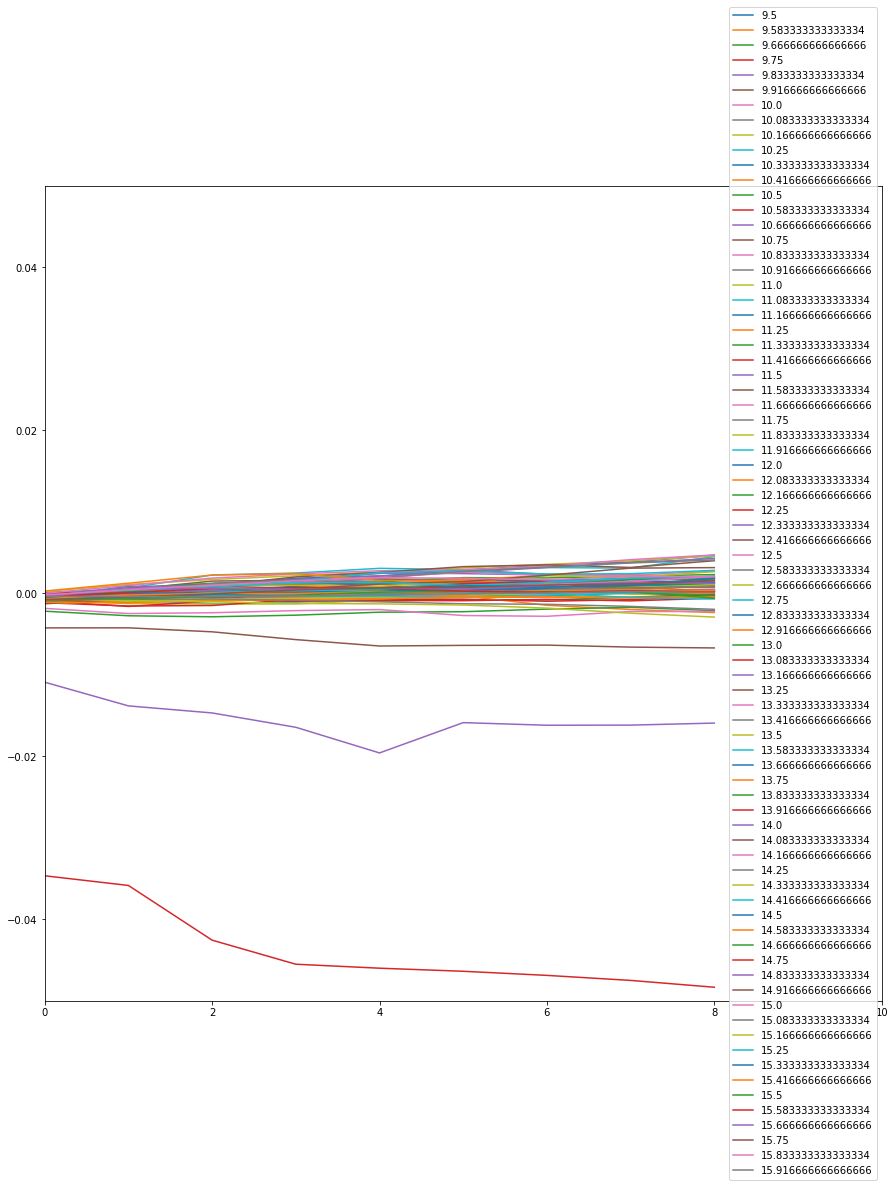

In [19]:
pd.pivot_table(R_06_dt.apply(pd.Series),columns=R_06_dt.index).plot(figsize=(15,15))
plt.legend(loc='right')
plt.xlim((0,10))
plt.ylim((-0.05,0.05))

So the flashcrash happened in dt=14.75 which is around 15.45 which is indeed correct

In [20]:
events_06[events_06.dt==14.75].head()

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume,mid,s,dt
xltime,,,,,,,,,
2010-05-06 14:45:00.203990399-04:00,108.748462,2400,108.80,1,108.97,4,108.885,-1.0,14.75
2010-05-06 14:45:00.207964800-04:00,108.765714,1500,108.69,13,108.72,4,108.705,1.0,14.75
2010-05-06 14:45:00.329011200-04:00,108.700000,380,108.70,7,108.72,10,108.710,-1.0,14.75
2010-05-06 14:45:00.400982400-04:00,108.720000,200,108.70,7,108.73,6,108.715,1.0,14.75
2010-05-06 14:45:00.414028800-04:00,108.705000,800,108.69,9,108.70,3,108.695,1.0,14.75


In [21]:
coarse_factor=5
events_05["dt"]=coarse_factor*((events_05.index.hour*60+events_05.index.minute)//coarse_factor)/60                            # chunks of 15 minutes
R_05_dt=events_05[["s","mid"]].groupby(events_05["dt"]).apply(compute_R,tau_max=10)
R_05_dt_plus=events_05[["s","mid"]][events_05["s"]>0].groupby(events_05["dt"]).apply(compute_R,tau_max=10)
R_05_dt_minus=events_05[["s","mid"]][events_05["s"]<0].groupby(events_05["dt"]).apply(compute_R,tau_max=10)

(-0.05, 0.05)

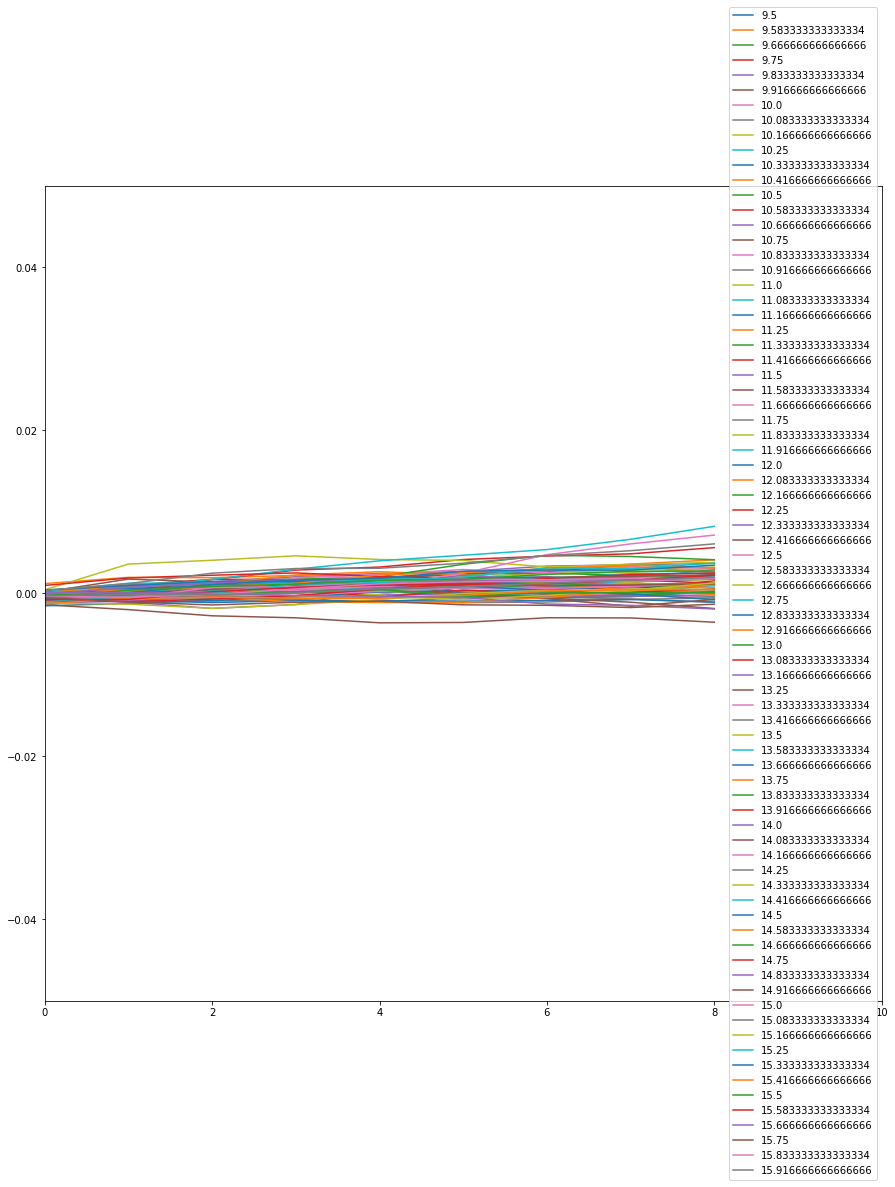

In [22]:
pd.pivot_table(R_05_dt.apply(pd.Series),columns=R_05_dt.index).plot(figsize=(15,15))
plt.legend(loc='right')
plt.xlim((0,10))
plt.ylim((-0.05,0.05))

Thus, what was special was a negative response function near the time of the crash.

Let us keep the first element of the response function, as a function of the time of the day:

(-0.002, 0.002)

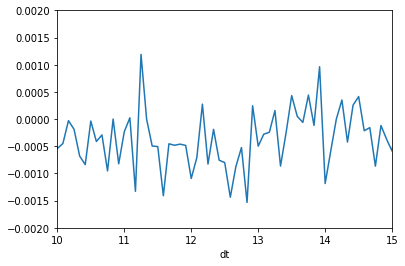

In [23]:
R_05_dt.apply(lambda x: x[0]).plot()
plt.xlim((10,15))
plt.ylim((-0.002,0.002))

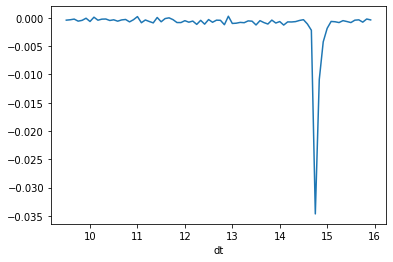

In [25]:
R_06_dt.apply(lambda x: x[0]).plot()
# plt.xlim((10,15))
# plt.ylim((-0.01,0.001))

Thus, the first response function coefficient kept decreasing until the time of the crash.

## Intraday correlation

In [26]:
def compute_mid_rets_nonzero(DF):
    ret=pd.DataFrame(np.log(DF["mid"]).diff())
    ret=ret[ret!=0]
    ret.dropna(inplace=True)
    return ret

In [27]:
def merge_returns(ret1,ret2):
    m=ret1.join(ret2,how="outer",rsuffix="_2")
    m.ffill(inplace=True)
    m.dropna(inplace=True)
    m=m[np.isfinite(m)]
    return m

In [28]:
ticker1="AAPL.OQ"
ticker2="BA.N"

events1=loadEvents(ticker1,"2010-05-05")
events2=loadEvents(ticker2,"2010-05-05")
ret1=compute_mid_rets_nonzero(events1)
ret2=compute_mid_rets_nonzero(events2)
m=merge_returns(ret1,ret2)
        

TypeError: 'NoneType' object is not subscriptable

In [29]:
def HY(m):   # leverages the ffill of merge_returns to multiply price returns in a causal way
    return np.mean(m["mid"]*m["mid_2"])/np.std(m["mid"])/np.std(m["mid_2"]) 

In [ ]:
m.groupby(m.index.hour).apply(HY)

In [ ]:
ticker1="AAPL.OQ"
ticker2="INTC.OQ"

events1=loadEvents(ticker1,"2010-05-06")
events2=loadEvents(ticker2,"2010-05-06")
ret1=compute_mid_rets_nonzero(events1)
ret2=compute_mid_rets_nonzero(events2)
m=merge_returns(ret1,ret2)

In [ ]:
m.groupby(m.index.hour).apply(HY)

In [ ]:
ticker1="AAPL.OQ"
ticker2="SPY.P"

events1=loadEvents(ticker1,"2010-05-06")
events2=loadEvents(ticker2,"2010-05-06")
ret1=compute_mid_rets_nonzero(events1)
ret2=compute_mid_rets_nonzero(events2)
m=merge_returns(ret1,ret2)
m.groupby(m.index.hour).apply(HY)

In [ ]:
dirBase="data/raw/TRTH/equities/US/"


ticker1="AAPL.OQ"
ticker2="SPY.P"

events1=loadEvents(ticker1,"2010-05-06")
events2=loadEvents(ticker2,"2010-05-06")
ret1=compute_mid_rets_nonzero(events1)
ret2=compute_mid_rets_nonzero(events2)
m=merge_returns(ret1,ret2)
m["r1r2"]=m["mid"]*m["mid_2"]   # covariance


In [ ]:
m["r1r2"].rolling(1000).mean().plot(figsize=(10,7))